## Dogs vs Cats

Представляем вам проектное задание нашей подгруппы №3. 
Участники: Дуняшина М.А., Коновалова Л.К., Кузнецова И.И., Мокробородова Ю.К. 
Вариант 1 -"Dogs vs Cats".

В качестве Data-файлов нами были взяты файлы из задания: 
    1) таблица samplesubmission.csv, содержащая в себе адреса и маркировки изображений; 
    2) архивы следующих изображений test1.zip (12500 файлов) и train.zip (25000 файлов). 
С их помощью и был реализован наш код.

Перед нами стояла задача написать такой алгоритм, который бы мог отличать кошек от собак. 
Для построения данной модели мы использовали библиотеку Keras, которая позволяет создавать нейронные сети.

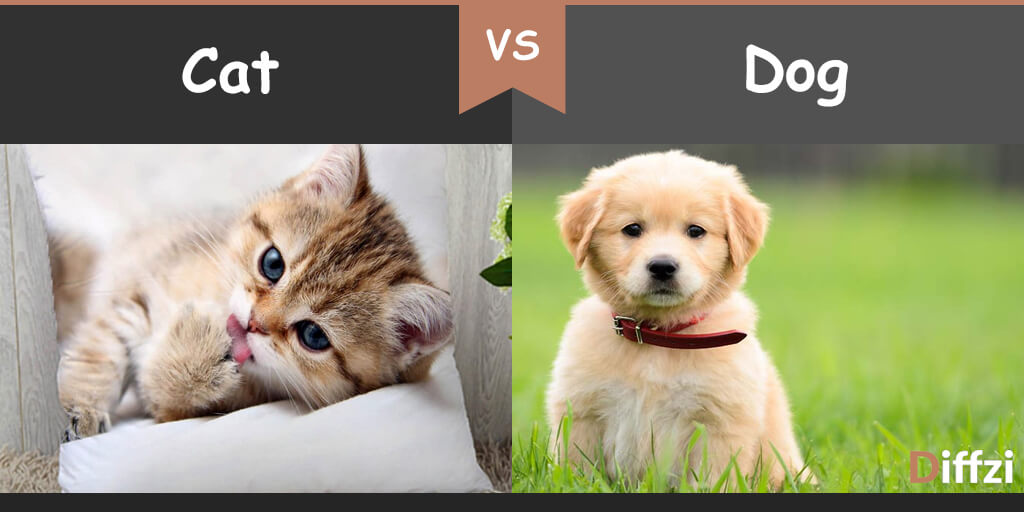

План разработки модели: 
1. Настройка набора данных
2. Предварительная обработка данных
3. Подготовка модели
 - Обратный вызов
 - Подготовка данных
 - Генератор
4. Построение модели обработки
5. Окончательная модель
6. Предиктивная аналитика

# 1. Настройка набора данных

## Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import zipfile
import os
print(os.listdir("../input/dogs-vs-cats"))

In [ ]:
# Чтение архивов
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [ ]:
# Количество наборов данных
print(len(os.listdir('/kaggle/working/train')), 'training data')
print(len(os.listdir('/kaggle/working/test1')), 'test data')

# 2. Обработка данных

In [ ]:
os.listdir("/kaggle/working/train")[:5]

In [ ]:
filenames = os.listdir("/kaggle/working/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':       # dog присваиваем 1
        categories.append(1)
    else:                       # cat присваиваем 0
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

In [ ]:
# просмотрт количества собак и кошек
df['category'].replace({0: 'cat', 1:'dog'}).value_counts()

In [ ]:
# визуализация категории 
df['category'].value_counts().plot.bar()

## Пример изображения

In [ ]:
sample = random.choice(filenames) # выбираем один случайный файл из filenames
image = load_img("/kaggle/working/train/" +sample) # получение имени случайно выбранного файла
plt.imshow(image) # изображение данного файла

# 3. Подготовка модели

## 1) Обратный вызов
> #### Вызываем функции (EarlyStopping, ReduceLROnPlateau)

> #### EarlyStopping - Early Stop
> - Код ниже определяет EarlyStopping, который отслеживает val_ass и останавливает обучение, если не было изменений n epoch.
>
> #### ReduceLRonPlateau - Learning Rate Reduction
> - Если val_acc не увеличивается в течение n epoch, то снижается скорость обучения.

In [ ]:
# импорт для использования досрочного прекращения обучения
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=15) # Раннее окончание обучения
#  Обучение прекращается, если значение val_loss не уменьшается при повышении на 15 пунктов

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_acc', # ReduceLROnPlateau : val_acc 
    patience = 2,        # количество epoch, которые не улучшились после снижения скорости обучения
    verbose = 1,         # указания, как должна отображаться данная информация (0, 1, 2)
                         # 0 : Выход без отображения на экране 
                         # 1 : EarlyStopping
    factor = 0.5,        # Значение фактора, которое определяет, насколько снизить скорость обучения  
                         # - ( learning rate = learning rate * factor )
    min_lr = 0.00001     # Нижний предел скорости обучения
)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

## 2) Prepare Data

In [ ]:
# Тип текущей категории : Целое число
df.head()

> #### Мы будем использовать class_mode =  'categorical' в генераторе ниже, поэтому нам нужно заменить его строкой. ( 1 - собака; 0 - кошка )

In [ ]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

df.head() 

In [ ]:
# train и vaild, temp_test классификация
train_valid_df, temp_test_df = train_test_split(df, test_size=0.02, random_state=42) # test_size = 0.02 : 2% от общего объема данных.
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2, random_state=42) # test_size = 0.2 : вычтем 2% из вышеперечисленного, и из оставшихся 98% данных - 20% являются действительными, 80% генерируются как train data

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
temp_test_df = temp_test_df.reset_index(drop=True)

train_df.shape, valid_df.shape, temp_test_df.shape

In [ ]:
train_df

In [ ]:
train_df['category'].value_counts()

In [ ]:
valid_df

In [ ]:
valid_df['category'].value_counts()

In [ ]:
total_train = train_df.shape[0]
total_validate = valid_df.shape[0]
total_temp_test = temp_test_df.shape[0]

In [ ]:
print(total_train, ',', total_validate, ',', total_temp_test)

## 3) Генератор (Увеличение данных)

In [ ]:
IMAGE_WIDTH = 128                        # Ширина изображения (строка)
IMAGE_HEIGHT = 128                       # Высота изображения (столбец)
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) # Размер изображения
IMAGE_CHANNELS = 3                       # Канал изображения (глубина)
batch_size = 32

In [ ]:
# # Увеличение данных для повышения производительности моделей нейронных сетей
train_datagen = ImageDataGenerator( # ImageDataGenerator : Случайное преобразование и нормализация изображений во время обучения
    rotation_range = 15,            # Произвольно поворот исходного изображения в пределах заданного угла(0 ~ 15) 
    rescale = 1./255,               # Масштабируем до 1/255 и преобразуем в диапазон 0-1
# Входное значение, состоящее из коэффициента RGB исходного изображения 0-255, слишком велико для эффективного изучения модели    shear_range = 0.1,              
    zoom_range = 0.2,               # Произвольное увеличение/уменьшение исходного изображения
    horizontal_flip = True,         # Инверсия влево и вправо: переверот изображения по горизонтали с вероятностью 50%
    width_shift_range = 0.1,        # Произвольное перемещение исходного изображения в пределах диапазона горизонтального перемещения - указывает отношение общей ширины
    height_shift_range = 0.1        # Произвольное перемещение исходного изображения в пределах диапазона вертикального перемещения-указывает отношение общей высоты
)

## Просмотр генератора

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True) 
example_generator = train_datagen.flow_from_dataframe(
    example_df, # dataframe
    "./train/", # Расположение каталога train
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

> #### Для классификации по категориям используем class_mode
> * #### 0 - cat, 1 - dog

<br>

> #### class_mode ( по умолчанию : категориальный )
> * #### binary : 1D numpy массив двоичных меток (1D numpy массив двоичных меток )
> * #### категориальный : 2D numpy массив меток с одним горячим кодированием. ( 2D numpy массив меток с одним горячим кодированием) -  Автоматическое выполнение одного горячего кодирования
> * #### разреженный: 1D numpy массив целочисленных меток ( 1D numpy массив целочисленных меток )
> * #### ввод: изображения, идентичные входным изображениям )


In [ ]:
# образец проверенных данных
example_df

In [ ]:
image = load_img("./train/" +example_df['filename'][0]) # Просмотр исходного изображения example_df
plt.imshow(image) # Импортированные файлы изображений

In [ ]:
plt.figure(figsize=(12, 12)) # Установка размера вывода графика
for i in range(0, 15):       # Вывод в общей сложности 15 изображений
    plt.subplot(5, 3, i+1)   # Установка вывода изображения
    for x_batch, y_batch in example_generator: # Преобразование исходного изображения с помощью exaple_generator를 통해 원본 이미지 변형
        image = x_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [ ]:
# Создание пакета дополненных/нормализованных данных,передав местоположение фрейма данных и каталога
train_generator = train_datagen.flow_from_dataframe( # Функция загрузки фрейма данных
    train_df,                                        
    "./train/",                                      # Путь к каталогу с полными данными
    x_col = 'filename',                              # train_df DataFrame на filename col получение значений
    y_col = 'category',                              # train_df DataFrame на category col получение значений
    target_size = IMAGE_SIZE,                        # Размеры для изменения размера всех изображений - значение по умолчанию (256, 256)
    class_mode = 'categorical', 
    batch_size = batch_size
)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    valid_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# 4. Модель обработки

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Activation, BatchNormalization


model = Sequential()

# block 1 ( Добавление реализации в 3*3 слоя )
model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))  # (126, 126, 32)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3, 3), strides=2))  # (62, 62, 64)
model.add(BatchNormalization())
model.add(Activation('relu'))


# block 2
model.add(Conv2D(64, (3, 3)))  # (60, 60, 64)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(128, (3, 3), strides=2))  # (29, 29, 128)
model.add(BatchNormalization())
model.add(Activation('relu'))


# block 3
model.add(Conv2D(128, (3, 3)))  # (27, 27, 128)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(256, (3, 3), strides=2))  # (13, 13, 256)
model.add(BatchNormalization())
model.add(Activation('relu')) 


# block 4
model.add(Conv2D(256, (3, 3)))  # (11, 11, 256)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(512, (3, 3), strides=2))  # (5, 5, 512)
model.add(BatchNormalization())
model.add(Activation('relu')) 


# block 5
model.add(Conv2D(512, (3, 3)))  # (3, 3, 512)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(1024, (3, 3), strides=2))  # (1, 1, 1024)
model.add(BatchNormalization())
model.add(Activation('relu')) 

# Output
model.add(GlobalAveragePooling2D()) # применяем усредненное объединение пространственных измерений до тех пор, пока каждое пространственное измерение не станет единым, и оставляет другие измерения неизменными

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))  # cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.summary()

## Подходящая модель

In [ ]:
epochs = 30
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='Validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## сохранение модели

In [ ]:
model.save_weights('model.h5')

# 6. Прогнозирование

> ## Прогнозирование Целевых Данных

In [ ]:
# test data
temp_test_datagen = ImageDataGenerator(rescale=1./255)
temp_test_generator = temp_test_datagen.flow_from_dataframe(
    temp_test_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict(
    temp_test_generator, # temp_test_generator : Генератор для входных выборок
    steps = np.ceil(total_temp_test/batch_size) # np.ceil : общее количество шагов от генератора до его подъема и остановки
)

In [ ]:
temp_test_df['predict'] = np.argmax(predict, axis=-1)

In [ ]:
temp_test_df

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())  # {0: 'cat', 1: 'dog'}


temp_test_df['category'] = temp_test_df['category'].replace(label_map)
temp_test_df['category'] = temp_test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
temp_test_df[0:100]

In [ ]:
accuracy_count = 0  # Количество правильных ответов

for i in range(total_temp_test):
    
    accuracy_count += ( temp_test_df['category'][i] == temp_test_df['predict'][i] )

print('Вероятность правильного ответа: {:.3f}'. format(float(accuracy_count/total_temp_test)))
print('Количество правильных ответов из 500: '.format(accuracy_count))

In [ ]:
check = temp_test_df.head(12)
check.head()
plt.figure(figsize=(12, 24))
for index, row in check.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Прогнозирование Тестовых Данных

In [ ]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame(
    {'filename': test_filenames}
)
test = test_df.shape[0]

In [ ]:
test

In [ ]:
test_df

In [ ]:
# test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict2 = model.predict(
    test_generator, # test_generator : генератор для входных выборок
    steps = np.ceil(test/batch_size) # np.ceil : Общее количество шагов от генератора до его подъема и остановки
)

In [ ]:
test_df['predict'] = np.argmax(predict2, axis=-1)

In [ ]:
test_df

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())  # {0: 'cat', 1: 'dog'}


test_df['predict'] = test_df['predict'].replace(label_map)
test_df['predict'] = test_df['predict'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df[0:100]

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['predict']
submission_df.drop(['filename', 'predict'], axis=1, inplace=True)
submission_df.to_csv('submission_final.csv', index=False)

In [ ]:
submission_df.head(10)

In [ ]:
check = test_df.head(12)
check.head()
plt.figure(figsize=(12, 24))
for index, row in check.iterrows():
    filename = row['filename']
    category = row['predict']
    img = load_img("/kaggle/working/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()